In [16]:
import numpy as np  # For array operations
import pandas as pd  # For Dataframe operations (similar to Excel spreadsheets)
from scipy.stats import norm

# For plotting figures
import matplotlib.pyplot as plt  
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                              AutoMinorLocator)

# Machine learning-realated functions
from sklearn.preprocessing import StandardScaler # For normalizing inputs
from sklearn.decomposition import PCA # Principle component analysis
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C ,WhiteKernel as Wht,Matern as matk

from tqdm.auto import tqdm  # progress bar

from warnings import filterwarnings # disable warnings
filterwarnings('ignore')

from IPython import display
%matplotlib inline 

In [17]:
# Loading pre-generated features
btzSol = pd.read_csv('BTZ-binarySolvents-features.csv')
Xsolvent = btzSol['Solvent']
X = btzSol[btzSol.columns[1:]]
print('Shape of input features = ',X.shape)
print(Xsolvent)
print(btzSol.columns[1:])

Shape of input features =  (2079, 11)
0       DME_0.1-DOX_0.9
1       DME_0.2-DOX_0.8
2       DME_0.3-DOX_0.7
3       DME_0.4-DOX_0.6
4       DME_0.5-DOX_0.5
             ...       
2074    APN_0.5-GTN_0.5
2075    APN_0.6-GTN_0.4
2076    APN_0.7-GTN_0.3
2077    APN_0.8-GTN_0.2
2078    APN_0.9-GTN_0.1
Name: Solvent, Length: 2079, dtype: object
Index(['TPSA_solv', 'MW_solv', 'HeavyAtomCount_solv', 'Gsolv_sol',
       'Dipole_sol', 'Polarizability_sol', 'HOMO_sol', 'LUMO_sol',
       'MaxPartialCharge_sol', 'MinPartialCharge_sol', 'LogP_sol'],
      dtype='object')


In [18]:
n_PC = 5  # Set number of principle components
st = StandardScaler()
Xdata = st.fit_transform(X)  # Normalize feature vectors

pca = PCA(n_components=n_PC)
Xdata = pca.fit_transform(Xdata)  # Transform feature vectors to PCs

In [19]:
# Define GPR and Acquisition functions
def gpregression(Xtrain,Ytrain,Nfeature):    
    cmean=[1.0]*Nfeature
    cbound=[[1e-3, 1e3]]*Nfeature
    kernel = C(1.0, (1e-3,1e3)) * matk(cmean,cbound,1.5) + Wht(1.0, (1e-3, 1e3))  # Matern kernel
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=40, normalize_y=False)
    gp.fit(Xtrain, Ytrain)
    return gp

# Predict result using GP regression model
def gprediction(gpnetwork,xtest):
    y_pred, sigma = gpnetwork.predict(xtest, return_std=True)
    return y_pred, sigma

# https://github.com/fmfn/BayesianOptimization/blob/master/bayes_opt/util.py

# Acquisition functions
def upperConfidenceBound(xdata,gpnetwork,epsilon):
    """
        xdata: input feature vectors or PCs of the REMAINING set
        gpnetwork: GPR model
        epsilon: control exploration/exploitation. Higher epsilon means more exploration
    """
    ye_pred, esigma = gprediction(gpnetwork, xdata)
    ucb = np.empty(ye_pred.size, dtype=float)
    for ii in range(0,ye_pred.size):
        if esigma[ii] > 0:
            ucb[ii]=(ye_pred[ii]+epsilon*esigma[ii])
        else:
            ucb[ii]=0.0
    return ucb

def probabilityOfImprovement(xdata,gpnetwork,ybest,epsilon):  
    "ybest: GPR-predicted best output property of the TRAINING set"

    ye_pred, esigma = gprediction(gpnetwork, xdata)
    poI = np.empty(ye_pred.size, dtype=float)
    for ii in range(0,ye_pred.size):
        if esigma[ii] > 0:
            zzval=(ye_pred[ii]-ybest-epsilon)/float(esigma[ii])
            poI[ii]=norm.cdf(zzval)
        else:
            poI[ii]=0.0
    return poI

def expectedImprovement(xdata,gpnetwork,ybest,epsilon): 
    ye_pred, esigma = gprediction(gpnetwork, xdata)
    expI = np.empty(ye_pred.size, dtype=float)
    for ii in range(0,ye_pred.size):
        if esigma[ii] > 0:
            zzval=(ye_pred[ii]-ybest)/float(esigma[ii])
            expI[ii]=(ye_pred[ii]-ybest-epsilon)*norm.cdf(zzval)+esigma[ii]*norm.pdf(zzval)
        else:
            expI[ii]=0.0
    return expI

In [20]:
# Load initial training set
ntrain = 40 # int(train_test_split * ndata)
ndata  = len(Xsolvent)
nremain = ndata - ntrain

solIniList = []
dfResults = pd.read_excel('BTZ-binarySolvents-ExpResults.xlsx', sheet_name='Sheet1')
solIni = dfResults['Solvent'][:40]
for i, solv in enumerate(solIni):
    solIniList.append(btzSol[btzSol.Solvent == solv].index[0])
print(solIniList)

dataset = np.random.RandomState(seed=10).permutation(ndata)
dataset = dataset.tolist()
for x in solIniList:
    dataset.remove(x)
dataset = solIniList + dataset

a1data = np.empty(ntrain, dtype=int)
a2data = np.empty(nremain, dtype=int)
a1data[:] = dataset[0:ntrain]
a2data[:] = dataset[ntrain:ndata]
# info for the initial training set
Xtrain = np.ndarray(shape=(ntrain, n_PC), dtype=float)
Xtraininfo = np.chararray(ntrain, itemsize=100)
Ytrain = np.empty(ntrain, dtype=float)
Xtrain[0:ntrain, :] = Xdata[a1data, :]
Xtraininfo[0:ntrain] = Xsolvent[a1data]

print('Initial solvents',Xtraininfo.decode())


[1641, 414, 1032, 1987, 1541, 1792, 1277, 416, 1643, 203, 1060, 1644, 1791, 1035, 1522, 2037, 1994, 820, 70, 33, 1122, 1224, 1295, 2040, 1640, 1642, 534, 155, 541, 2028, 435, 1588, 307, 420, 358, 153, 1814, 1645, 443, 1453]
Initial solvents ['OT_0.4-HMPA_0.6' 'ATN_0.1-CH_0.9' 'BA_0.7-HP_0.3' 'NMP_0.8-GTN_0.2'
 'HP_0.3-CHO_0.7' 'PX_0.2-HMPA_0.8' 'CH_0.9-HP_0.1' 'ATN_0.3-CH_0.7'
 'OT_0.6-HMPA_0.4' 'DOX_0.6-DMF_0.4' 'BA_0.8-PX_0.2' 'OT_0.7-HMPA_0.3'
 'PX_0.1-HMPA_0.9' 'BA_0.1-OT_0.9' 'HP_0.2-OX_0.8' 'HMPA_0.4-APN_0.6'
 'CHO_0.6-HMPA_0.4' 'DMA_0.2-HMPA_0.8' 'DME_0.8-CH_0.2' 'DME_0.7-DMA_0.3'
 'BA_0.7-APN_0.3' 'DMSO_0.1-HMPA_0.9' 'CH_0.9-PA_0.1' 'HMPA_0.7-APN_0.3'
 'OT_0.3-HMPA_0.7' 'OT_0.5-HMPA_0.5' 'ATN_0.4-GTN_0.6' 'DME_0.3-HMPA_0.7'
 'DMF_0.2-DMA_0.8' 'HMPA_0.4-BTN_0.6' 'ATN_0.4-HP_0.6' 'OT_0.5-PA_0.5'
 'DOX_0.2-OX_0.8' 'ATN_0.7-CH_0.3' 'DOX_0.8-APN_0.2' 'DME_0.1-HMPA_0.9'
 'PX_0.6-APN_0.4' 'OT_0.8-HMPA_0.2' 'ATN_0.3-OT_0.7' 'TOL_0.5-HMPA_0.5']


In [21]:
# Display initial training set in a table
dfResults = pd.read_excel('BTZ-binarySolvents-ExpResults.xlsx', sheet_name='Sheet1')
solvId = dfResults.SolventID[0:ntrain].values
Solv = dfResults.Solvent[0:ntrain].values
Y = dfResults.logS[0:ntrain].values
print('*** Results for first '+str(ntrain)+' molecules ***')
print(115*'-')
print('{:<80s}{:<15s}'.format('Solvent','logS'))
print(115*'-')
for i in range(ntrain):
    print('{:<80s}{:<15f}'.format(Solv[i],Y[i]))
print(115*'-')
Ytrain = Y
print('Initial y values',Ytrain)

yoptLoc = np.argmax(Ytrain)
yopttval = Ytrain[yoptLoc]
xoptval = Xtraininfo[yoptLoc]
yoptstep=0
yopinit = yopttval
xoptint = xoptval

# info for the remaining data set
Xremain = np.ndarray(shape=(nremain, n_PC), dtype=float)
Xremaininfo = np.chararray(nremain, itemsize=100)
Yremain = np.empty(nremain, dtype=float)
Xremain[0:nremain, :] = Xdata[a2data, :]
Xremaininfo[0:nremain] = Xsolvent[a2data]
print("Xremain: ", Xremain.shape)
print("Xremaininfo: ", Xremaininfo.shape)

*** Results for first 40 molecules ***
-------------------------------------------------------------------------------------------------------------------
Solvent                                                                         logS           
-------------------------------------------------------------------------------------------------------------------
OT_0.4-HMPA_0.6                                                                 0.634000       
ATN_0.1-CH_0.9                                                                  0.560879       
BA_0.7-HP_0.3                                                                   0.580917       
NMP_0.8-GTN_0.2                                                                 0.730121       
HP_0.3-CHO_0.7                                                                  0.695279       
PX_0.2-HMPA_0.8                                                                 0.719401       
CH_0.9-HP_0.1                                            

Current training dataset has 120 members
0 OT_0.4-HMPA_0.6
1 ATN_0.1-CH_0.9
2 BA_0.7-HP_0.3
3 NMP_0.8-GTN_0.2
4 HP_0.3-CHO_0.7
5 PX_0.2-HMPA_0.8
6 CH_0.9-HP_0.1
7 ATN_0.3-CH_0.7
8 OT_0.6-HMPA_0.4
9 DOX_0.6-DMF_0.4
10 BA_0.8-PX_0.2
11 OT_0.7-HMPA_0.3
12 PX_0.1-HMPA_0.9
13 BA_0.1-OT_0.9
14 HP_0.2-OX_0.8
15 HMPA_0.4-APN_0.6
16 CHO_0.6-HMPA_0.4
17 DMA_0.2-HMPA_0.8
18 DME_0.8-CH_0.2
19 DME_0.7-DMA_0.3
20 BA_0.7-APN_0.3
21 DMSO_0.1-HMPA_0.9
22 CH_0.9-PA_0.1
23 HMPA_0.7-APN_0.3
24 OT_0.3-HMPA_0.7
25 OT_0.5-HMPA_0.5
26 ATN_0.4-GTN_0.6
27 DME_0.3-HMPA_0.7
28 DMF_0.2-DMA_0.8
29 HMPA_0.4-BTN_0.6
30 ATN_0.4-HP_0.6
31 OT_0.5-PA_0.5
32 DOX_0.2-OX_0.8
33 ATN_0.7-CH_0.3
34 DOX_0.8-APN_0.2
35 DME_0.1-HMPA_0.9
36 PX_0.6-APN_0.4
37 OT_0.8-HMPA_0.2
38 ATN_0.3-OT_0.7
39 TOL_0.5-HMPA_0.5
40 DME_0.1-DOX_0.9
41 DOX_0.9-HMPA_0.1
42 DME_0.2-DOX_0.8
43 DME_0.3-DOX_0.7
44 DOX_0.9-BA_0.1
45 DOX_0.8-HMPA_0.2
46 DOX_0.9-DMF_0.1
47 DOX_0.9-NMP_0.1
48 DOX_0.9-DMA_0.1
49 DME_0.4-DOX_0.6
50 DOX_0.9-OX_0.1
51 DOX_0.7-HMP

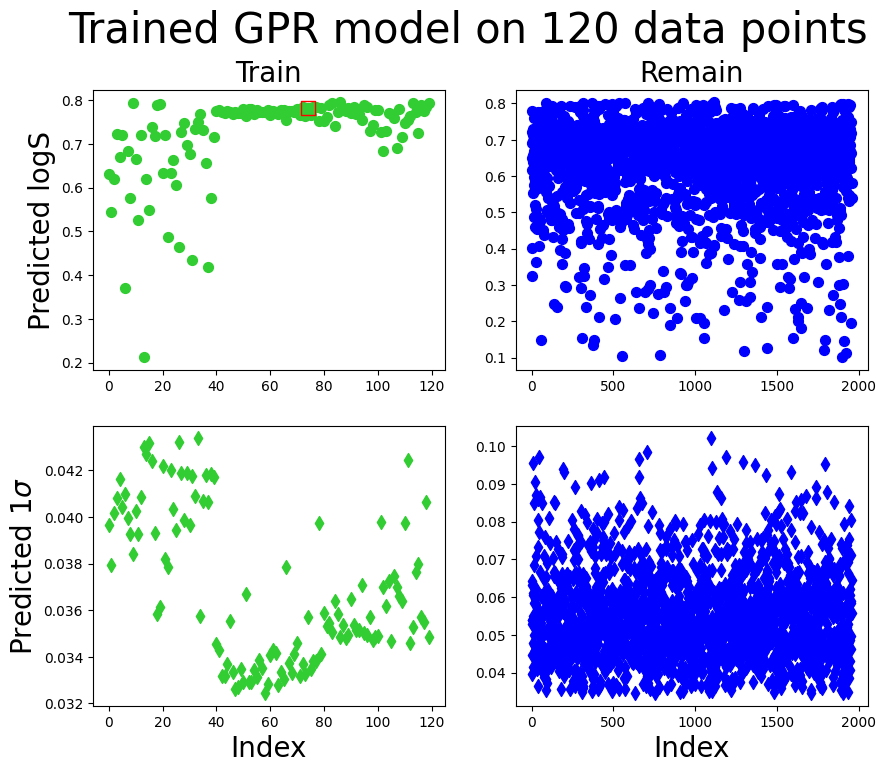

In [25]:
# This is the start of the new loop after updating the training set (retrain GPR model with new training set)
fig, axs = plt.subplots(2,2)
fig.set_size_inches(10,8)
titleSize=30
axisTitleSize=20
markerSize=50
print('Current training dataset has',len(Xtraininfo),'members')
for i,x in enumerate(Xtraininfo):
    print(i,Xtraininfo[i].decode())
fig.suptitle('Trained GPR model on '+str(len(Xtraininfo))+' data points',fontsize=titleSize)
gpnetwork = gpregression(Xtrain, Ytrain, n_PC)

yt_pred, tsigma = gprediction(gpnetwork, Xtrain)
ybestloc = np.argmax(Ytrain) # The current best y value
ybest_pred = yt_pred[ybestloc]
axs[0,0].scatter(np.arange(len(yt_pred)),yt_pred,color='limegreen',s=markerSize)
axs[0, 0].set_title('Train', fontsize=axisTitleSize)
axs[1,0].scatter(np.arange(len(tsigma)),tsigma,color='limegreen',marker='d',s=markerSize)
axs[0,0].scatter(ybestloc,ybest_pred,color='r',marker='s',s=markerSize+50,facecolor='None')

yr_pred, rsigma = gprediction(gpnetwork, Xremain)
axs[0,1].scatter(np.arange(len(yr_pred)),yr_pred,color='b',s=markerSize)
axs[0, 1].set_title('Remain',fontsize=axisTitleSize)
axs[1,1].scatter(np.arange(len(rsigma)),rsigma,color='b',marker='d',s=markerSize)

axs[0,0].set_ylabel('Predicted logS',fontsize=axisTitleSize)
axs[1,0].set_xlabel('Index',fontsize=axisTitleSize)
axs[1,0].set_ylabel('Predicted 1$\sigma$',fontsize=axisTitleSize)
axs[1,1].set_xlabel('Index',fontsize=axisTitleSize)

rmse = np.sqrt(np.mean((yt_pred-Ytrain)**2))
print('Current GPR error: RMSE = ', rmse)
plt.show()

Computing EI on the remaining 2039 data points
[0.01998435 0.01953597 0.01933813 0.01931755 0.01930885 0.0190072
 0.01877817 0.01868021 0.01863976 0.01809161 0.01805907 0.01742996
 0.01738242 0.01726995 0.01724978 0.01701838 0.01693701 0.0169364
 0.01689576 0.01673602 0.01658616 0.01644137 0.01644021 0.01635424
 0.01621771 0.0160573  0.015703   0.01550868 0.01549051 0.01541257
 0.01523605 0.01491152 0.01489859 0.01474331 0.01453387 0.01445339
 0.01426483 0.01421209 0.01410707 0.0140809 ]
[1113, 1946, 15, 715, 315, 571, 537, 451, 86, 369, 1015, 926, 126, 1005, 1600, 1837, 495, 1106, 1894, 637, 1047, 708, 780, 1058, 1884, 1907, 1936, 1481, 1493, 1548, 1542, 311, 1934, 1355, 92, 711, 1130, 759, 515, 298]
DME_0.7-OX_0.3 1113
['DME_0.7-OX_0.3', 'DOX_0.6-DMSO_0.4', 'DOX_0.7-ATN_0.3', 'DME_0.7-PX_0.3', 'DME_0.7-MX_0.3', 'DME_0.8-OX_0.2', 'DME_0.8-MX_0.2', 'DME_0.6-OX_0.4', 'DME_0.8-PX_0.2', 'DME_0.8-TOL_0.2', 'DOX_0.5-DMSO_0.5', 'DME_0.9-TOL_0.1', 'DOX_0.5-DMF_0.5', 'DME_0.6-MX_0.4', 'DME_0.6

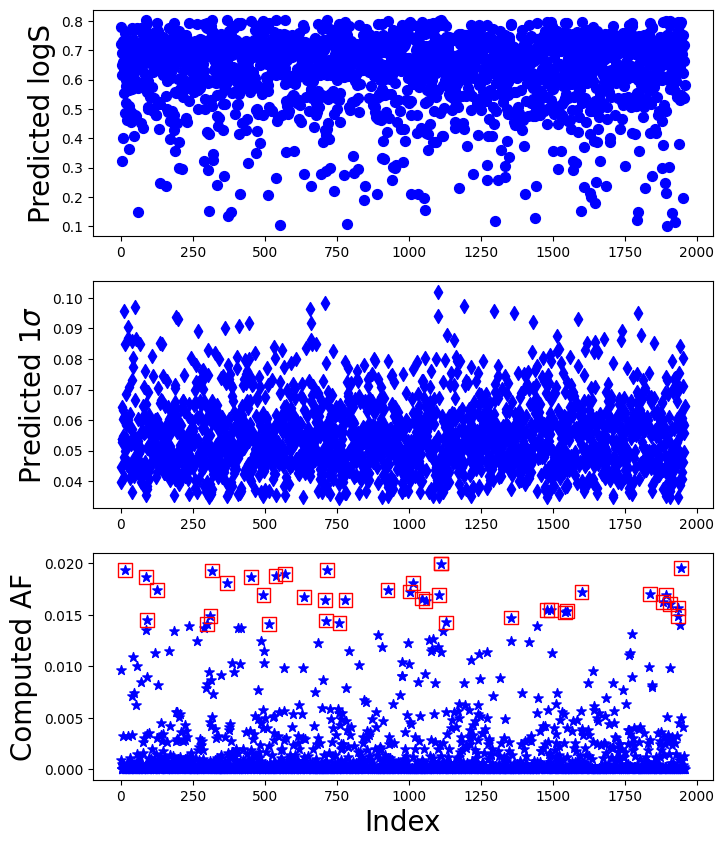

List of new solvent(s) to be eavaluated: 
121 DME_0.7-OX_0.3
122 DOX_0.6-DMSO_0.4
123 DOX_0.7-ATN_0.3
124 DME_0.7-PX_0.3
125 DME_0.7-MX_0.3
126 DME_0.8-OX_0.2
127 DME_0.8-MX_0.2
128 DME_0.6-OX_0.4
129 DME_0.8-PX_0.2
130 DME_0.8-TOL_0.2
131 DOX_0.5-DMSO_0.5
132 DME_0.9-TOL_0.1
133 DOX_0.5-DMF_0.5
134 DME_0.6-MX_0.4
135 DME_0.6-PX_0.4
136 DOX_0.4-DMF_0.6
137 DME_0.9-MX_0.1
138 DME_0.9-PX_0.1
139 DME_0.9-OX_0.1
140 DOX_0.8-ATN_0.2
141 DOX_0.7-DMSO_0.3
142 DOX_0.6-ATN_0.4
143 DME_0.7-TOL_0.3
144 DOX_0.6-PA_0.4
145 DME_0.9-DMSO_0.1
146 DME_0.9-CH_0.1
147 DME_0.9-HP_0.1
148 DME_0.9-OT_0.1
149 DME_0.8-DMSO_0.2
150 DME_0.8-DMF_0.2
151 DME_0.9-DMF_0.1
152 DME_0.7-DMF_0.3
153 DOX_0.5-PA_0.5
154 DOX_0.3-DMF_0.7
155 DME_0.9-DMA_0.1
156 DOX_0.4-DMSO_0.6
157 DOX_0.7-PA_0.3
158 DME_0.6-DMF_0.4
159 DME_0.8-DMA_0.2
160 DME_0.9-NMP_0.1


In [26]:
# Compute acquisition function
fig, axs = plt.subplots(3)
fig.set_size_inches(8,10)
selectionSize = 40  # How many new solvents to be selected
print('Computing EI on the remaining '+str(ndata-ntrain)+' data points')
epsilon = 0.01 # Control exploration/exploitation
expI = expectedImprovement(Xremain, gpnetwork, ybest_pred, epsilon)
AFsorted = np.sort(expI)[::-1]  # sort and reverse order from ascending (default) to descending
AFtop = AFsorted[:selectionSize]
print(AFtop)

AFtopIndList = []
XsolventNew = []
for af in AFtop:
    ind = np.where(expI==af)
    AFtopIndList.append(ind[0][0])
print(AFtopIndList)
AFmax = np.max(expI)
AFmaxloc = np.argmax(expI)
print(Xremaininfo[AFmaxloc].decode(),AFmaxloc)

for ind in AFtopIndList:
    XsolventNew.append(Xremaininfo[ind].decode())

print(XsolventNew)
axs[0].scatter(np.arange(len(yr_pred)),yr_pred,color='b',s=markerSize)
axs[0].set_ylabel('Predicted logS',fontsize=axisTitleSize)

axs[1].scatter(np.arange(len(rsigma)),rsigma,color='b',marker='d',s=markerSize)

axs[1].set_ylabel('Predicted 1$\sigma$',fontsize=axisTitleSize)


axs[2].scatter(np.arange(len(expI)),expI,color='b',marker='*',s=markerSize)
axs[2].scatter(AFmaxloc,AFmax,edgecolor='r',marker='s',s=markerSize+50,facecolor='None')
for i in AFtopIndList:
    axs[2].scatter(i,expI[i],edgecolor='r',marker='s',s=markerSize+50,facecolor='None')
axs[2].set_xlabel('Index',fontsize=axisTitleSize)
axs[2].set_ylabel('Computed AF',fontsize=axisTitleSize)

plt.show()
print('List of new solvent(s) to be eavaluated: ')
for i,solv in enumerate(XsolventNew):
    print(len(Xtrain)+i+1,solv)

In [24]:
# For inputing all training data in at once
import pandas as pd

n_iniSet = 40
n_iter = 2 # after the initial selection
samples_per_iter = 40
total_samples = n_iniSet + (n_iter*samples_per_iter)
print(total_samples)


dfResults = pd.read_excel('BTZ-binarySolvents-ExpResults.xlsx', sheet_name='Sheet1')

for i in range(n_iniSet, total_samples):
    Solnew = dfResults.Solvent[i]
    expimaxloc = Xremaininfo.decode().tolist().index(Solnew)
    Ynew = dfResults['logS'][i]
    xnew = np.append(Xtrain, Xremain[expimaxloc]).reshape(-1, n_PC)
    xnewinfo = np.append(Xtraininfo, Xremaininfo[expimaxloc])
    ynew = np.append(Ytrain, Ynew)
    xrnew = np.delete(Xremain, expimaxloc, 0)
    xrnewinfo = np.delete(Xremaininfo, expimaxloc)
    Xtrain = xnew
    Xtraininfo = xnewinfo
    Ytrain = ynew
    Xremain = xrnew
    Xremaininfo = xrnewinfo
    del xnew, xnewinfo, ynew, xrnew, xrnewinfo

print(115*'-')
print('{:<5s}{:<80s}{:<15s}'.format('ID','Solvent','logS'))
print(115*'-')
for i,x in enumerate(Xtraininfo):
    print('{:<5d}{:<80s}{:<15f}'.format(i,Xtraininfo[i].decode(),Ytrain[i]))

120
-------------------------------------------------------------------------------------------------------------------
ID   Solvent                                                                         logS           
-------------------------------------------------------------------------------------------------------------------
0    OT_0.4-HMPA_0.6                                                                 0.634000       
1    ATN_0.1-CH_0.9                                                                  0.560879       
2    BA_0.7-HP_0.3                                                                   0.580917       
3    NMP_0.8-GTN_0.2                                                                 0.730121       
4    HP_0.3-CHO_0.7                                                                  0.695279       
5    PX_0.2-HMPA_0.8                                                                 0.719401       
6    CH_0.9-HP_0.1                                       